In [1]:
# import gdown
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# import os
import pandas as pd

# import pyro
# import pyro.distributions as pyrodist
import scanpy as sc
import seaborn as sns

# import time
import torch
import torch.utils.data
import torchvision.utils as vutils
import umap
import skimage as skim
from abc import abstractmethod
from anndata.experimental.pytorch import AnnLoader
from importlib import reload
from math import pi, sin, cos, sqrt, log

# from pyro.infer import SVI, JitTrace_ELBO, Trace_ELBO, TraceGraph_ELBO
# from pyro.optim import Adam
import sklearn
from sklearn import datasets as skds
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import mixture
from toolz import partial, curry
from torch import nn, optim, distributions, Tensor
from torch.nn.functional import one_hot
from torchvision import datasets, transforms, models
from torchvision.utils import save_image, make_grid
from typing import Callable, Iterator, Union, Optional, TypeVar
from typing import List, Set, Dict, Tuple
from typing import Mapping, MutableMapping, Sequence, Iterable
from typing import Union, Any, cast, IO, TextIO
from torch.utils.data import WeightedRandomSampler

# my own sauce
from my_torch_utils import denorm, normalize, mixedGaussianCircular
from my_torch_utils import fclayer, init_weights, buildNetwork
from my_torch_utils import fnorm, replicate, logNorm, log_gaussian_prob
from my_torch_utils import plot_images, save_reconstructs, save_random_reconstructs
from my_torch_utils import scsimDataset
import my_torch_utils as ut
from importlib import reload
from torch.nn import functional as F
import gmmvae03 as M3
import gmmvae04 as M4
import gmmvae05 as M5
import gmmvae06 as M6
import gmmvae07 as M7
import gmmvae08 as M8
import gmmvae09 as M9
import gmmvae10 as M10
import gmmvae11 as M11
import gmmvae12 as M12
import gmmvae13 as M13
import gmmvae14 as M14
import gmmvae15 as M15
import gmmTraining as Train

print(torch.cuda.is_available())


True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [2]:
plt.ion()
sc.settings.verbosity = 3
sc.logging.print_header()
# sc.settings.set_figure_params(dpi=120, facecolor='white', )
# sc.settings.set_figure_params(figsize=(8,8), dpi=80, facecolor='white', )
sc.settings.set_figure_params(
    dpi=80,
    facecolor="white",
)

enc = OneHotEncoder(sparse=False, dtype=np.float32)
enc_ct = LabelEncoder()
enc_ct2 = LabelEncoder()


scanpy==1.8.2 anndata==0.7.8 umap==0.5.2 numpy==1.22.1 scipy==1.7.3 pandas==1.4.0 scikit-learn==1.0.2 statsmodels==0.13.1 python-igraph==0.9.9 louvain==0.7.1 pynndescent==0.5.6


In [47]:
#################################################################################
### RNA seq
# https://anndata-tutorials.readthedocs.io/en/latest/annloader.html
# https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html
#################################################################################
#adata = sc.read("./data/GTEx_8_tissues_snRNAseq_atlas_071421.public_obs.h5ad",)
#sc.pp.highly_variable_genes(adata, n_top_genes=1000, inplace=True, subset=True,)
adata = sc.read("./data/pancreas_2.h5ad")
print(adata.obs.columns)
print(adata)


Index(['celltype', 'sample', 'n_genes', 'batch', 'n_counts', 'louvain'], dtype='object')
AnnData object with n_obs × n_vars = 14693 × 2448
    obs: 'celltype', 'sample', 'n_genes', 'batch', 'n_counts', 'louvain'
    var: 'n_cells-0', 'n_cells-1', 'n_cells-2', 'n_cells-3'
    uns: 'celltype_colors', 'louvain', 'neighbors', 'pca', 'sample_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'


/home/ykolb/miniconda3/envs/torch/lib/python3.9/site-packages/anndata/compat/__init__.py:180: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/home/ykolb/miniconda3/envs/torch/lib/python3.9/site-packages/anndata/compat/__init__.py:180: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(


In [17]:
adata.X.mean(1)
adata.X.max(1)
adata.X.min(1)
adata.obs["batch"]
adata.raw.X.shape,  adata.n_obs, adata.n_vars

((14693, 24516), 14693, 2448)

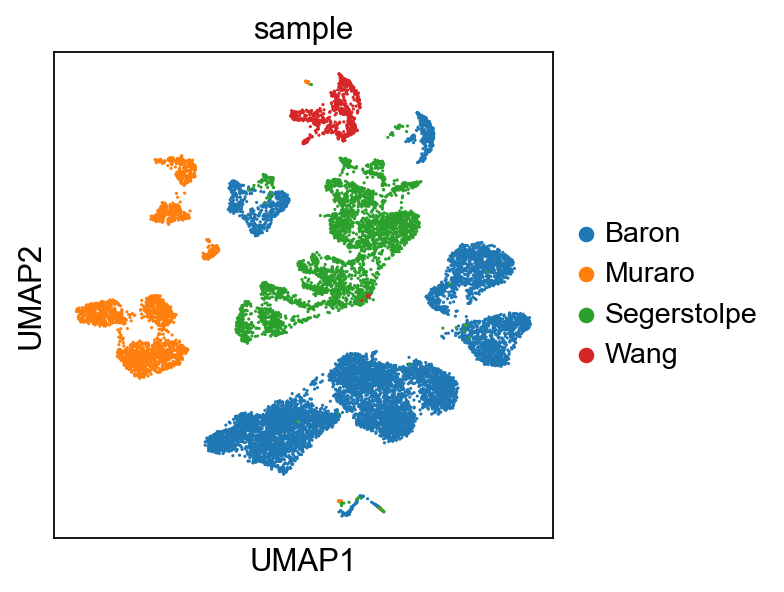

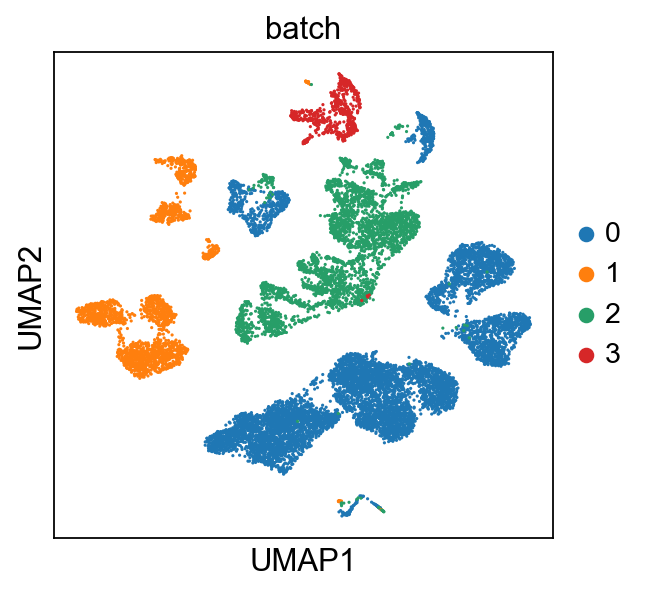

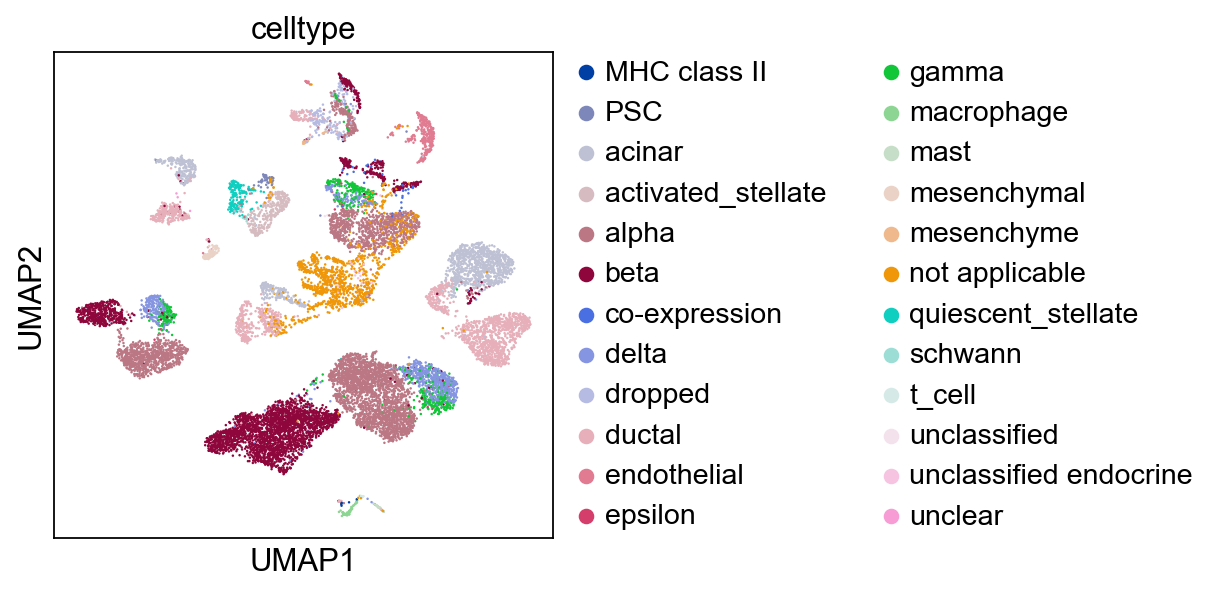

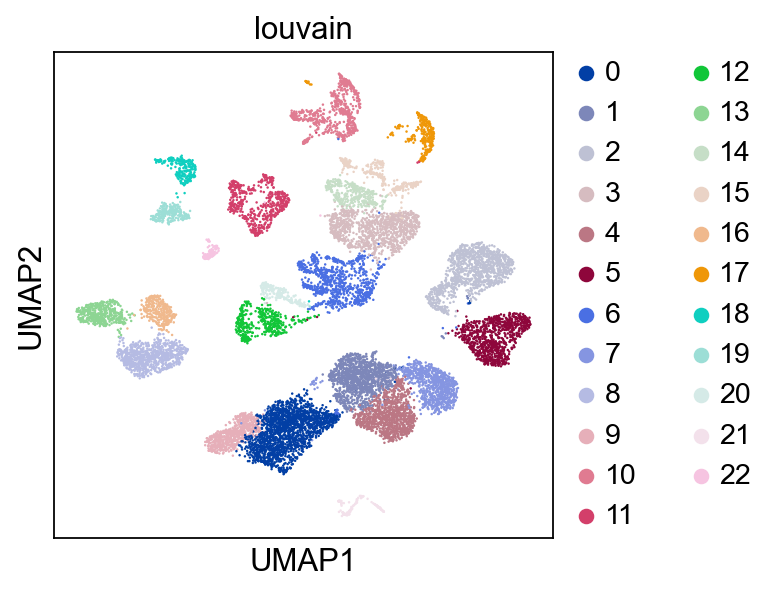

In [15]:
sc.pl.umap(adata, color=['sample', ], wspace=0.35)
sc.pl.umap(adata, color=['batch', ], wspace=0.35)
sc.pl.umap(adata, color=['celltype',], size=5, wspace=5)
sc.pl.umap(adata, color=['louvain',], size=5, wspace=5)

In [48]:
data = torch.FloatTensor(adata.X)
enc_ct.fit(adata.obs["celltype"])
enc_ct2.fit(adata.obs["sample"])
labels = torch.IntTensor(
        enc_ct.transform(adata.obs["celltype"]))
labels = F.one_hot(labels.long(), num_classes=enc_ct.classes_.size).float()
conds = torch.IntTensor(
        enc_ct2.transform(adata.obs["sample"]))
conds = F.one_hot(conds.long(), num_classes=enc_ct2.classes_.size).float()
#dataset = ut.SynteticDataSet(data, labels)
#dataset = ut.SynteticDataSetV2(dati=[data, labels, conds])
subset = ut.randomSubset(s=len(labels), r=0.11)
data_loader = torch.utils.data.DataLoader(
        dataset=ut.SynteticDataSetV2(dati=[data, labels, conds]),
        batch_size=128,
        shuffle=True,
        )

labeled_data_loader = torch.utils.data.DataLoader(
        dataset=ut.SynteticDataSetV2(
            dati=[data[subset], labels[subset], conds[subset]]),
        batch_size=128,
        shuffle=True,
        )
unlabeled_data_loader = torch.utils.data.DataLoader(
        dataset=ut.SynteticDataSetV2(
            dati=[data[subset == False], labels[subset == False], conds[subset == False]]),
        batch_size=128,
        shuffle=True,
        )


In [51]:
reload (M15)
reload (Train)
model1502c = M15.VAE_Dirichlet_GMM_Type1502C(
    nx=adata.n_vars,
    nh=1024*2,
    nhp=1024*2,
    nhq=1024*2,
    nz=64,
    nw=32,
    numhidden=4,
    numhiddenp=4,
    numhiddenq=4,
    dropout=0.25,
    use_resnet=False,
    nclasses=labels.shape[1] * 3,
    nc1 = 4,
    yscale=1e0,
    dscale=1e0,
    mi_scale=1e0,
    cc_scale=1e1,
    temperature=0.15,
    do_cc=False,
    softargmax=False,
    eps=1e-6,
    concentration=1.5e0,
    restrict_w=True,
    restrict_z=True,
    reclosstype="mse",
    learned_prior = True,
    activation=nn.LeakyReLU(),
        )
model1502c.apply(init_weights)
model1502c.nclasses


True
True


72

In [52]:
Train.basicTrainLoopCond(
    model1502c,
    unlabeled_data_loader,
    labeled_data_loader,
    num_epochs=30,
    lrs = [1e-5, 1e-4, 1e-3, 1e-3, 1e-4, 1e-5],
    device="cuda",
    wt=0,
    report_interval=38,
    do_plot=False,
    test_accuracy=True,
)


epoch's lr =  1e-05
epoch 0
training phase
rec: 3217.35986328125
loss_z: 54.88117218017578
loss_w: 191.37179565429688
loss_cluster: -0.08993008732795715
loss_d: 116.15471649169922
loss_y_alt: 1.855302333831787
loss_y_alt2: 0
total_loss: 3581.622802734375
num_clusters: 0

[-1. -1.  5.  5. 17. -1. -1. -1. -1. -1. -1.  4.  5. -1.  5. -1. -1. -1.
 -1. -1. -1. -1.  4. -1. -1.  5.  4. -1.  2.  4. -1. -1.  4.  2. -1. -1.
  9.  5. 17. -1.  2. -1. -1. -1.  2.  7. -1. -1. -1. 12. -1.  4.  5. -1.
 -1.  4. -1. -1. -1. -1.  4.  4. -1. -1. -1. -1. -1. -1.  4. -1. -1. -1.] 
 -0.4247127872127872 
 [-1.         -1.          1.          1.          1.         -1.
 -1.         -1.         -1.         -1.         -1.          0.25
  1.         -1.          0.5        -1.         -1.         -1.
 -1.         -1.         -1.         -1.          0.25       -1.
 -1.          0.6         0.6        -1.          1.          0.33333333
 -1.         -1.          1.          0.5        -1.         -1.
  0.2272727

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:08)


/home/ykolb/miniconda3/envs/torch/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'pred' as categorical


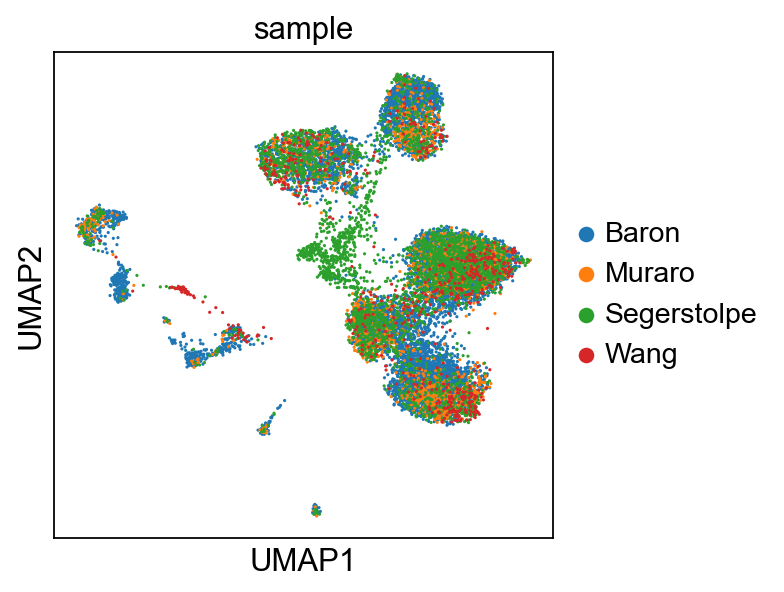

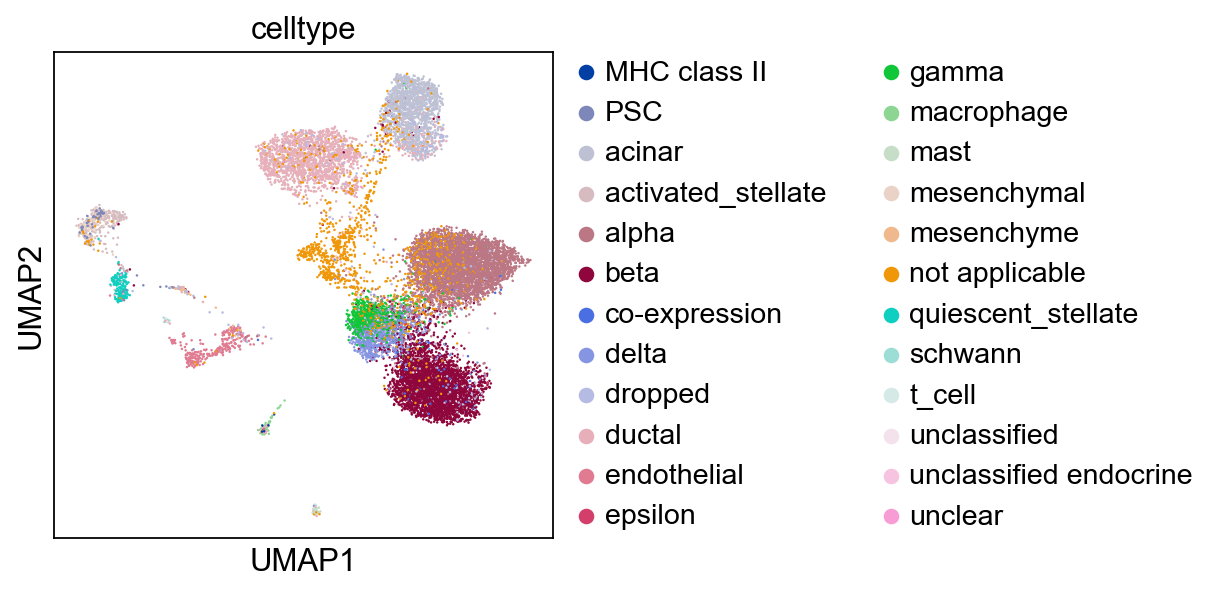

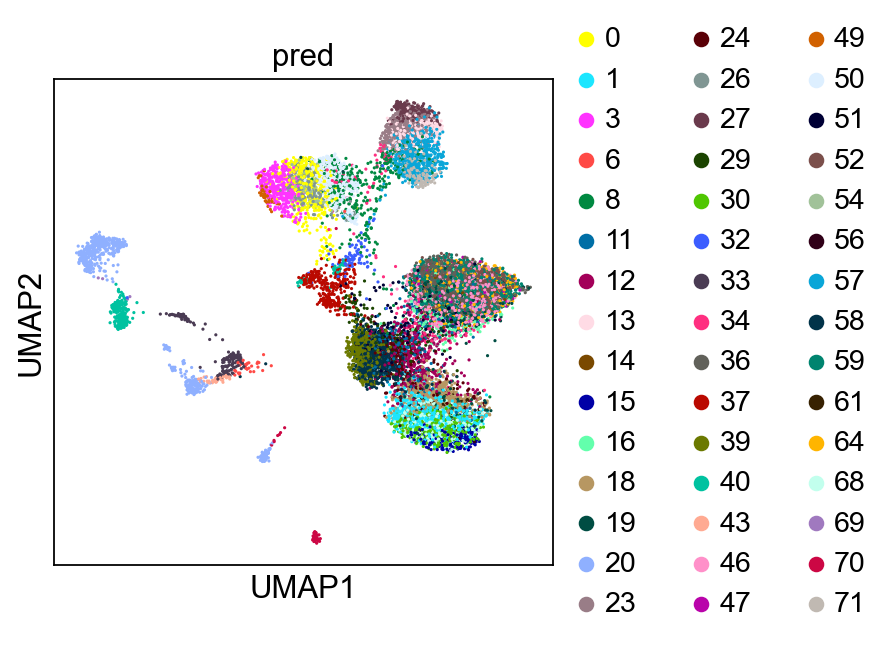

In [53]:
model1502c.cpu()
model1502c.eval()
#output = model1501c(data, cond1=conds)
output = model1502c(data, cond1=conds, y=None)
adata.obsm["z"] = output["z"].detach().numpy()
adata.obs["pred"] = output["q_y"].detach().argmax(-1).numpy().astype(str)
#adata.obsm["w"] = output["w"].detach().numpy()
del output
sc.pp.neighbors(adata, use_rep="z",)
sc.tl.umap(adata,)
sc.pl.umap(adata, color=['sample', ], wspace=0.35)
sc.pl.umap(adata, color=['celltype'], size=5, wspace=5)
sc.pl.umap(adata, color=['pred'], wspace=0.35 )

In [54]:
reload (M15)
reload (Train)
model1502c2 = M15.VAE_Dirichlet_GMM_Type1502C(
    nx=adata.n_vars,
    nh=1024*2,
    nhp=1024*2,
    nhq=1024*2,
    nz=64,
    nw=32,
    numhidden=4,
    numhiddenp=4,
    numhiddenq=4,
    dropout=0.25,
    use_resnet=False,
    nclasses=labels.shape[1],
    nc1 = 4,
    yscale=1e0,
    dscale=1e0,
    mi_scale=1e0,
    cc_scale=1e1,
    temperature=0.15,
    do_cc=False,
    softargmax=False,
    eps=1e-6,
    concentration=1.5e0,
    restrict_w=True,
    restrict_z=True,
    reclosstype="mse",
    learned_prior = True,
    activation=nn.LeakyReLU(),
        )
model1502c.apply(init_weights)
model1502c.nclasses


True
True


72

In [55]:
Train.trainSemiSuperLoopCond(
    model1502c2,
    labeled_data_loader,
    unlabeled_data_loader,
    labeled_data_loader,
    num_epochs=80,
    lrs = [1e-5, 1e-4, 1e-3,1e-3,1e-4,1e-5],
    device="cuda",
    wt=0,
    do_unlabeled=True,
    do_validation=False,
    report_interval=65,
    do_plot=False,
    test_accuracy=True,
)


epoch 0
labeled phase
rec: 2417.054931640625
loss_z: 17.396514892578125
loss_w: 8.725171089172363
loss_cluster: -0.08334846049547195
loss_d: 6.897410869598389
loss_y_alt: 3.7381510734558105
loss_y_alt2: 3.1976406574249268
total_loss: 2457.009765625
num_clusters: 0

[-1. -1. -1. -1. -1. -1. -1. -1.  5.  4.  4.  5.  4.  4. -1.  5. -1.  4.
  4. -1. -1. -1. -1. -1.] 
 -0.42824675324675326 
 [-1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.          0.54545455  0.4         1.          0.26666667
  0.28571429  1.         -1.          0.5        -1.          0.42424242
  0.3        -1.         -1.         -1.         -1.         -1.        ]
0.5663716814159292 

unlabeled phase
rec: 2364.581298828125
loss_z: 14.895395278930664
loss_w: 3.3890626430511475
loss_cluster: -0.08626232296228409
loss_d: 5.16532564163208
loss_y_alt: 0.7108005881309509
loss_y_alt2: 0
total_loss: 2388.741943359375
num_clusters: 0

epoch 65
labeled phase
rec: 1840.2862548828125
loss_z: 7.2

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:08)


/home/ykolb/miniconda3/envs/torch/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'pred' as categorical


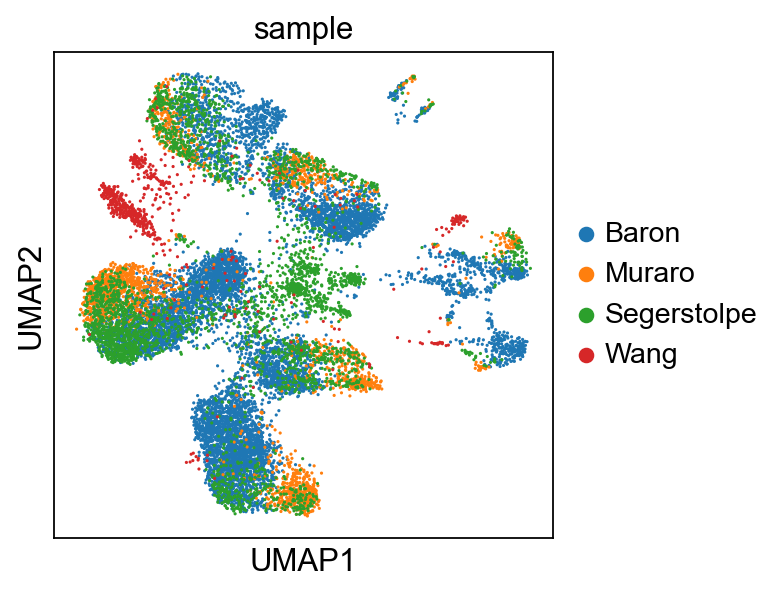

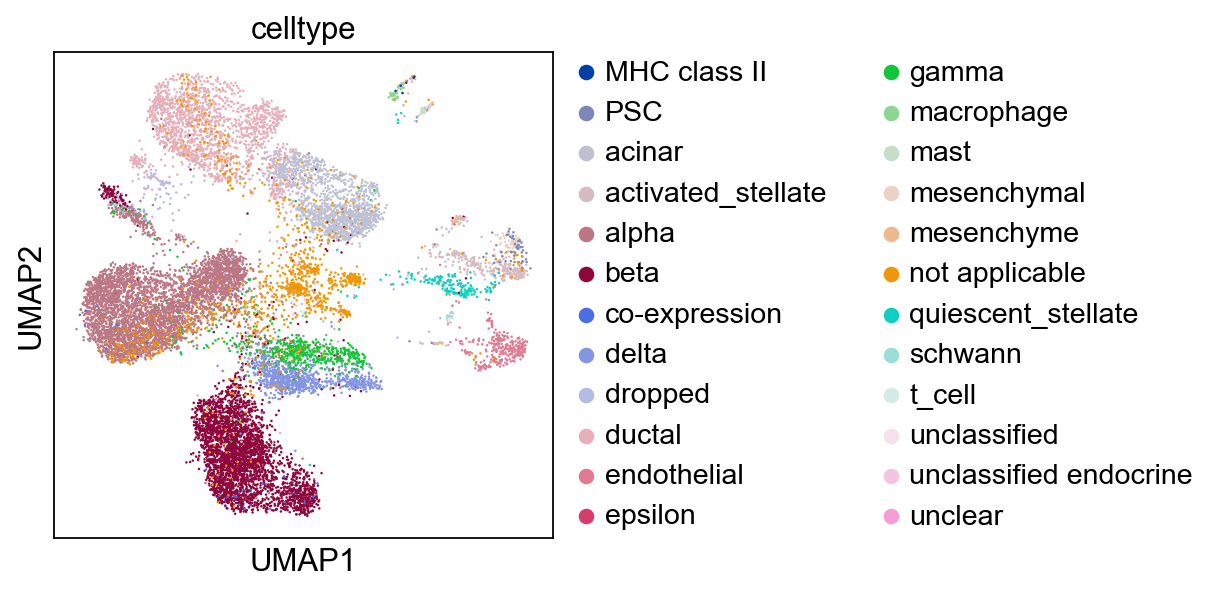

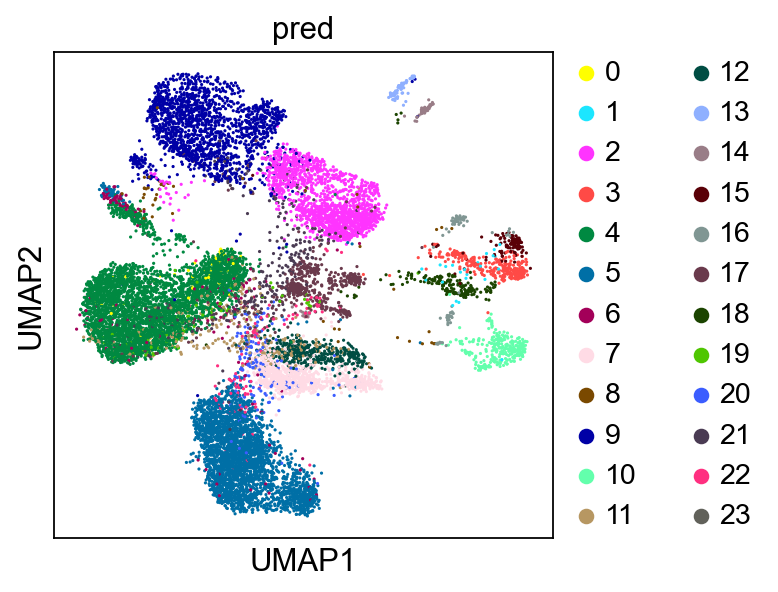

In [56]:
model1502c2.cpu()
model1502c2.eval()
#output = model1501c(data, cond1=conds)
output = model1502c2(data, cond1=conds, y=None)
adata.obsm["z"] = output["z"].detach().numpy()
adata.obs["pred"] = output["q_y"].detach().argmax(-1).numpy().astype(str)
#adata.obsm["w"] = output["w"].detach().numpy()
del output
sc.pp.neighbors(adata, use_rep="z",)
sc.tl.umap(adata,)
sc.pl.umap(adata, color=['sample', ], wspace=0.35)
sc.pl.umap(adata, color=['celltype'], size=5, wspace=5)
sc.pl.umap(adata, color=['pred'], wspace=0.35 )
